In [10]:
import re

def remove_sql_comments(query):
    """ Cleans SQL queries by removing comments and unnecessary whitespace. """
    query = re.sub(r'--.*', '', query)  # Remove single-line comments
    query = re.sub(r'/\*.*?\*/', '', query, flags=re.DOTALL)  # Remove multi-line comments
    query = query.replace('\t', ' ')  # Replace tabs with spaces
    query = query.replace('\n', ' ')  # Remove newlines
    query = re.sub(r'\s+', ' ', query)  # Collapse multiple spaces
    query = re.sub(r'\s*,\s*', ', ', query)  # Remove spaces around commas
    query = re.sub(r'\s*\(\s*', ' (', query)  # Remove spaces before opening parenthesis
    query = re.sub(r'\s*\)\s*', ') ', query)  # Remove spaces after closing parenthesis
    return query.strip()

# Define the query types in the order they appear
query_types = [
    "set_operation",
    "group_by",
    "aggregated",
    "join",
    "nested"
]

# Initialize a dictionary to store the queries by type
query_dict = {type: [] for type in query_types}

# Read and clean SQL queries from the file, then categorize them
with open("divided_sql_query.sql", 'r') as file:
    file_content = file.read()
    raw_queries = file_content.split(';')  # Split the file content into individual queries

    # Process each query, assume exactly 5 queries per type
    for index, query in enumerate(raw_queries):
        cleaned_query = remove_sql_comments(query)
        if cleaned_query:  # Check for non-empty queries
            type_index = index // 5  # Determine the type index
            if type_index < len(query_types):  # Ensure the index is within the defined types
                query_dict[query_types[type_index]].append(cleaned_query)

import json
json.dump(query_dict, open('queries.json', 'w'))


In [12]:
from sql_metadata import Parser

def replace_table_names(query, suffix):
    parser = Parser(query)
    for table in parser.tables:
        new_table_name = f"{table}_{suffix}"
        query = re.sub(r'\b' + re.escape(table) + r'\b', new_table_name, query)
    return query

# Define the query types and suffixes
query_types = ["set_operation", "group_by", "aggregated", "join", "nested"]
suffixes = ["orc_none", "orc_snappy", "parquet_gzip","orc_zlib", "parquet_none"]

# Initialize a dictionary to store the queries by type
query_dict = {type: [] for type in query_types}

# Read and clean SQL queries from the file
with open("divided_sql_query.sql", 'r') as file:
    file_content = file.read()
    raw_queries = file_content.split(';')

    # Process each query, assume exactly 5 queries per type
    for index, query in enumerate(raw_queries):
        cleaned_query = remove_sql_comments(query)
        if cleaned_query:
            type_index = index // 5
            if type_index < len(query_types):
                query_dict[query_types[type_index]].append(cleaned_query)

# Process each suffix and save to separate JSON files
for suffix in suffixes:
    modified_queries = {type: [replace_table_names(query, suffix) for query in queries] for type, queries in query_dict.items()}
    with open(f'queries_{suffix}.json', 'w') as json_file:
        json.dump(modified_queries, json_file)

In [7]:
!pip install Jason

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for Jason: filename=jason-0.1.7-py3-none-any.whl size=2629 sha256=6f3894fadbe7e52f6bc79e22d881e64f7c568d6c8087e692af39c3ba4be1556d
  Stored in directory: c:\users\kinjalk parth\appdata\local\pip\cache\wheels\d3\e3\80\fdd1001c3ccfcb52f6470928d3b8cf0c28026009473a7d9103
Successfully built Jason


<Figure size 1000x600 with 0 Axes>

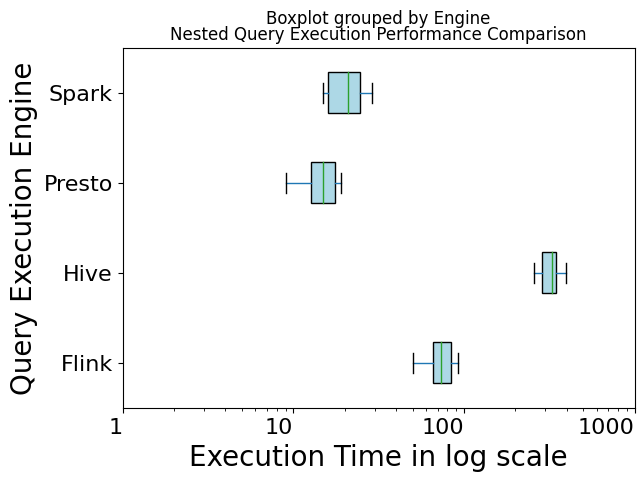

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data into a pandas DataFrame
df = pd.read_csv('query-execution-type5.csv')

# Melt the DataFrame to have one column for the query and one column for the engine
melted_df = df.melt(id_vars='Query', var_name='Engine', value_name='Execution Time')

# Create the box plot
plt.figure(figsize=(10, 6))
ax = melted_df.boxplot(column='Execution Time', by='Engine', patch_artist=True, vert=False, grid=False, boxprops=dict(facecolor='lightblue'))

# Add labels and title
plt.xlabel('Execution Time in log scale', fontsize=20)
plt.ylabel('Query Execution Engine', fontsize=20)
plt.title('Nested Query Execution Performance Comparison')


# Convert the x-axis to log scale
ax.set_xscale('log')

# Create custom tick labels for the x-axis
tick_labels = [1, 10, 100, 1000]
ax.set_xticks(tick_labels)
ax.set_xticklabels([str(x) for x in tick_labels])

# Adjust the x-axis tick labels to be more readable
plt.xticks(rotation=0, ha='right')

plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

# Display the plot
plt.show()

In [28]:
import re

# Read the SQL queries from the file
with open("divided_sql_query.sql", 'r') as file:
    queries = file.read().split(';')  # Assuming each query ends with a ';'


def filter_queries_by_type(queries, query_type):
    # Filter queries to only include those with the specified type in their leading comment
    filtered_queries = []
    for query in queries:
        # Check if the leading comment matches the specified query type
        match = re.search(r'-- QUERY_\d+ - (\w+)', query)
        if match and match.group(1).lower() == query_type.lower():
            query = re.sub(r'--.*', '', query)
            query = re.sub(r'/\*.*?\*/', '', query, flags=re.DOTALL)
            query = query.replace('\n', '')
            query = query.replace('\t', '')
            filtered_queries.append(query)
    return filtered_queries

queries = filter_queries_by_type(queries, 'joins')

for i in range(len(queries)):
    print(queries[i])

select     w_state  ,i_item_id  ,sum(case when (cast(d_date as date) < cast ('2001-05-02' as date))  then cs_sales_price - coalesce(cr_refunded_cash,0) else 0 end) as sales_before  ,sum(case when (cast(d_date as date) >= cast ('2001-05-02' as date))  then cs_sales_price - coalesce(cr_refunded_cash,0) else 0 end) as sales_after from   catalog_sales left outer join catalog_returns on       (cs_order_number = cr_order_number         and cs_item_sk = cr_item_sk)  ,warehouse   ,item  ,date_dim where     i_current_price between 0.99 and 1.49 and i_item_sk          = cs_item_sk and cs_warehouse_sk    = w_warehouse_sk  and cs_sold_date_sk    = d_date_sk and d_date between (cast ('2001-05-02' as date) - 30 days)                and (cast ('2001-05-02' as date) + 30 days)  group by    w_state,i_item_id order by w_state,i_item_idlimit 100
select  channel, item, return_ratio, return_rank, currency_rank from (select 'web' as channel ,web.item ,web.return_ratio ,web.return_rank ,web.currency_rank fro